In [1]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import statsmodels.tsa.stattools as ts
import datetime

yf.pdr_override()

/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
TRAIN_TEST_RATIO = 0.2

In [3]:
covid_pharma_tickers = ['PFE', 'MRNA', 'JNJ', 'AZN', 'NVAX']
start = '2020-03-01'
end = datetime.datetime.now().date().strftime('%Y-%m-%d')
print(f"Period: {start} to {end}")

Period: 2020-03-01 to 2020-08-09


In [4]:
prices = pdr.get_data_yahoo(covid_pharma_tickers, start=start, end=end)['Adj Close']
prices.tail()

Symbols,PFE,MRNA,JNJ,AZN,NVAX
Date,,,,,
2020-08-03,38.349998,77.980003,147.350006,56.820000,155.869995
2020-08-04,38.389999,78.459999,147.220001,56.080002,157.169998
2020-08-05,38.450001,75.800003,148.399994,55.950001,173.490005
2020-08-06,38.270000,73.760002,147.550003,56.209999,167.500000
2020-08-07,38.450001,74.099998,148.600006,55.410000,170.289993


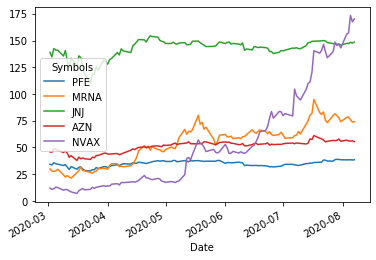

In [5]:
prices.plot()

In [6]:
from pandas.plotting import lag_plot, autocorrelation_plot

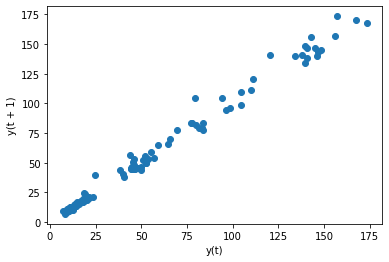

In [7]:
lag_plot(prices['NVAX'])

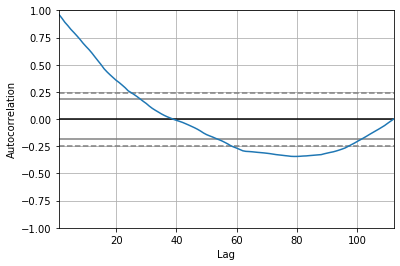

In [8]:
autocorrelation_plot(prices['NVAX'])

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

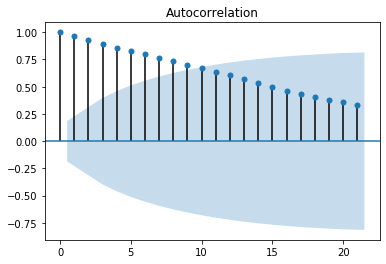

In [10]:
_ = plot_acf(prices['NVAX'])

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

In [12]:
train, test = train_test_split(prices['NVAX'], test_size=TRAIN_TEST_RATIO, shuffle=False)
start_train = train.index[0].to_pydatetime()
end_train = train.index[-1].to_pydatetime()
start_test = test.index[0].to_pydatetime()
end_test = test.index[-1].to_pydatetime()
print(f"Fitting model from {start_train} to {end_train}")
print(f"Predicting from {start_test} to {end_test}")

Fitting model from 2020-03-02 00:00:00 to 2020-07-07 00:00:00
Predicting from 2020-07-08 00:00:00 to 2020-08-07 00:00:00


In [13]:
def fit_model(train, model_wrapper, test_ratio=0.1):
    # train autoregression
    m = model_wrapper(train)
    m_fit = m.fit()
    # plot residual
    residuals = pd.DataFrame(m_fit.resid)
    residuals.plot()
    residuals.plot(kind='kde')
    return m_fit

/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATIO

Lag: 12
Coefficients: const      -0.176568
L1.NVAX     0.949609
L2.NVAX     0.008945
L3.NVAX     0.069541
L4.NVAX     0.106677
L5.NVAX     0.058705
L6.NVAX    -0.514357
L7.NVAX     0.446195
L8.NVAX    -0.287279
L9.NVAX     0.189082
L10.NVAX    0.014432
L11.NVAX   -0.154552
L12.NVAX    0.168950
dtype: float64


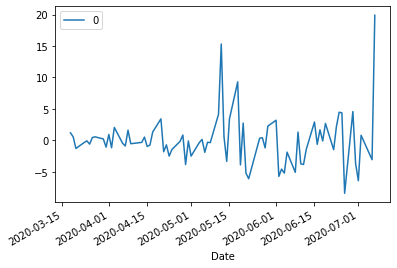

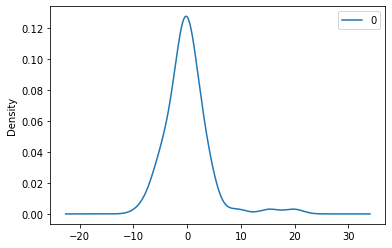

In [14]:
# usage
ar_wrapper = lambda train_data: AR(train_data)
ar_fit = fit_model(train, ar_wrapper, TRAIN_TEST_RATIO)
print(f"Lag: {ar_fit.k_ar}")
print(f"Coefficients: {ar_fit.params}")

In [15]:
def predict(m_fit, start, end, **kwargs):
    # make predictions
    predictions = m_fit.predict(start=start, end=end, **kwargs)
    for i in range(len(predictions)):
        print(f'predicted={predictions.values[i]}, expected={test.values[i]}')
    print(predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test RMSE: {rmse}')
    # plot result
    plt.plot(test.values)
    plt.plot(predictions.values, color='red')
    plt.show()

predicted=102.83003666318464, expected=98.30000305175781
predicted=106.81201882602487, expected=96.30000305175781
predicted=110.51789485670524, expected=94.36000061035156
predicted=115.42953778745981, expected=104.31999969482422
predicted=126.75119340223537, expected=109.97000122070312
predicted=120.97336131858219, expected=111.1500015258789
predicted=130.69403586816904, expected=120.29000091552734
predicted=131.49773002814754, expected=140.49000549316406
predicted=137.6112403179611, expected=138.22999572753906
predicted=142.83461851677225, expected=140.69000244140625
predicted=140.3806231875534, expected=146.4499969482422
predicted=151.06062793483747, expected=139.58999633789062
predicted=151.48717774419495, expected=133.92999267578125
predicted=160.62860766837213, expected=139.60000610351562
predicted=163.46021398011194, expected=148.60000610351562
predicted=167.90071521258653, expected=145.36000061035156
predicted=178.38557524897644, expected=146.6199951171875
predicted=180.17912585

/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


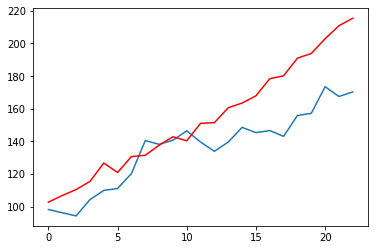

In [16]:
predict(ar_fit, len(train), len(train)+len(test)-1)

/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(

                             ARIMA Model Results                              
Dep. Variable:                 D.NVAX   No. Observations:                   88
Model:                 ARIMA(7, 1, 5)   Log Likelihood                -264.136
Method:                       css-mle   S.D. of innovations                nan
Date:                Sun, 09 Aug 2020   AIC                            556.272
Time:                        16:25:18   BIC                            590.955
Sample:                             1   HQIC                           570.245
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.8185        nan        nan        nan         nan         nan
ar.L1.D.NVAX    -0.2138   1.68e-06  -1.27e+05      0.000      -0.214      -0.214
ar.L2.D.NVAX     0.2875        nan        na

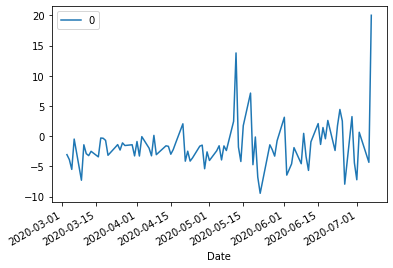

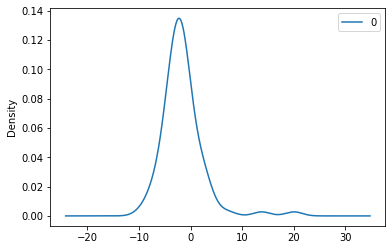

In [17]:
arima_wrapper = lambda train_data: ARIMA(train_data, order=(7,1,5))
arima_fit = fit_model(train, arima_wrapper)
print(arima_fit.summary())


/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/kyle.nguyen/miniconda3/envs/quant/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


predicted=103.71056289271316, expected=98.30000305175781
predicted=105.92032984892091, expected=96.30000305175781
predicted=108.29909201926857, expected=94.36000061035156
predicted=113.40401447762385, expected=104.31999969482422
predicted=120.14213123241144, expected=109.97000122070312
predicted=114.51420448494551, expected=111.1500015258789
predicted=120.70580481161437, expected=120.29000091552734
predicted=122.07098040080679, expected=140.49000549316406
predicted=125.42647272744767, expected=138.22999572753906
predicted=128.77560854156587, expected=140.69000244140625
predicted=125.66816653368738, expected=146.4499969482422
predicted=133.76255155556035, expected=139.58999633789062
predicted=132.47048029476335, expected=133.92999267578125
predicted=136.25136266524788, expected=139.60000610351562
predicted=138.41586242296722, expected=148.60000610351562
predicted=137.57861373850605, expected=145.36000061035156
predicted=145.02161115172314, expected=146.6199951171875
predicted=142.069020

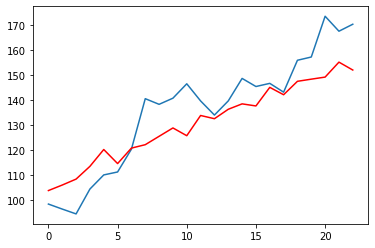

In [18]:
# make predictions
predict(arima_fit, len(train), len(train)+len(test)-1, typ='levels')